**Цель** - предсказать цены на квартиры в датасете test.csv.
Даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).


Данные уже содержат в себе целевую переменную Price, так что задача относится к классу задач машинного обучения с учителем

In [1]:
import numpy as np
import pandas as pd
import random

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
# Переопределена ниже
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [5]:
# https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe/39734251#39734251
def missing_values_table(df):
    """ """
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

# Загрузка данных

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

In [7]:
# считываем данные в DataFrame
train_df = pd.read_csv(TRAIN_DATASET_PATH)

# выводим первые 4 признака
train_df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630


In [8]:
print('Строк в тренировочной выборке:', train_df.shape[0])
print('Признаков в тренировочной выборке:', train_df.shape[1])
# print('Строк в тесте', test_df.shape[0])

Строк в тренировочной выборке: 10000
Признаков в тренировочной выборке: 20


**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [9]:
train_df.shape

(10000, 20)

In [10]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

id уникальный для данной выборки, поэтому заменим тип на object. DistrictId признак категориальный, его тоже заменим на object

In [11]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

In [12]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Целевая переменная**

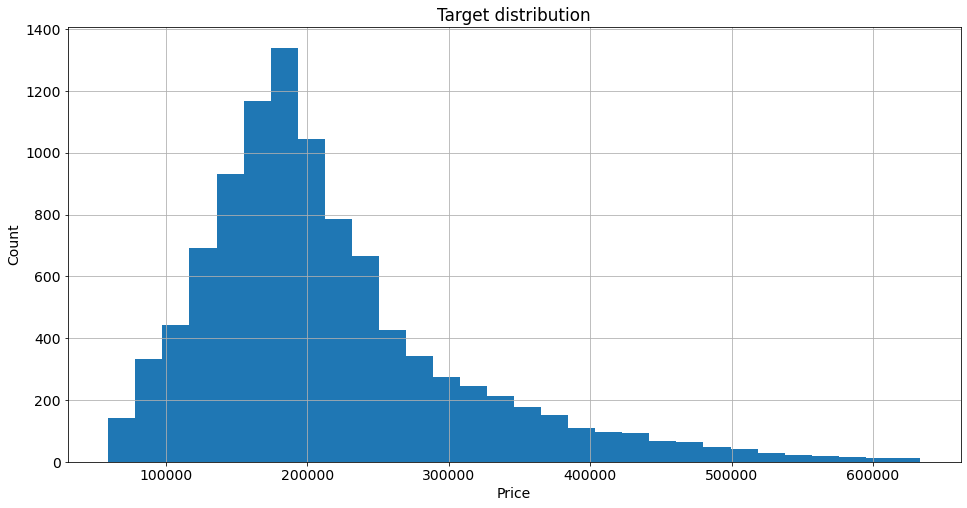

In [13]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Номинативные переменные**

In [14]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [15]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
205      1
196      1
207      1
174      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [16]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [17]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [18]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка выбросов  <a class='anchor' id='outlier'>

**Rooms**

In [19]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [20]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [21]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**KitchenSquare** 

In [22]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [23]:
condition_kitchen = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))

In [24]:
train_df['KitchenSquare_outlier'] = 0
train_df.loc[condition_kitchen, 'KitchenSquare_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,B,305018.871089,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,B,177734.553407,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,B,282078.720850,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,1,264,0,NaN,0,1,B,168106.007630,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,33,8667,2,NaN,0,6,B,343995.102962,0,0


In [25]:
train_df[['KitchenSquare_outlier']].value_counts()

KitchenSquare_outlier
0                        9811
1                         189
dtype: int64

За минимальную площадь кухни принимаем 3, выбросы заменены на медиану

In [26]:
train_df.loc[condition_kitchen, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [27]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

**HouseFloor, Floor**

Обрабатываем случаи когда квартира расположена на этаже большем, чем есть в доме

In [28]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [29]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [30]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [31]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [32]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [33]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [34]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

Значения года больше текущего заменяем на текущий

In [35]:
current_year = datetime.now().year

train_df['HouseYear_outlier'] = 0
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1

In [36]:
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear'] = current_year
train_df[train_df['HouseYear'] > current_year]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,HouseYear_outlier


**LifeSquare**

In [37]:
train_df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [38]:
train_df['LifeSquare'].quantile(.975), train_df['LifeSquare'].quantile(.025)

(80.74810407514713, 5.914129735023812)

Минимальная LifeSquare принимаем 10 и отбрасываем значения выше 97,5 %

In [39]:
condition_life_square = (train_df['LifeSquare'].isna()) \
             | (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.975))
        
train_df.loc[condition_life_square, 'LifeSquare'] = train_df['LifeSquare'].median()

train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [40]:
train_df['LifeSquare'].describe()

count    10000.000000
mean        34.222355
std         12.482189
min         10.000000
25%         25.527399
50%         32.781260
75%         39.966602
max         80.664209
Name: LifeSquare, dtype: float64

<AxesSubplot:>

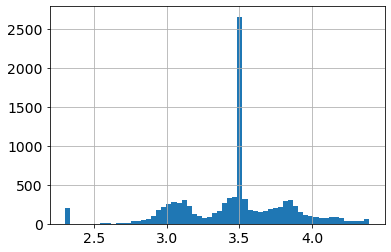

In [41]:
np.log(train_df['LifeSquare']).hist(bins = 60)

**Square**

Считаем выбросами всё что находится выше 99%.

In [42]:
condition_max_square = train_df['Square'] > train_df['Square'].quantile(.99)
train_df.loc[condition_max_square, 'Square'] = train_df['Square'].quantile(.99)

Обрабатываем малые значения Square

In [43]:
condition_min_square = train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'] + 3 
condition_min_square.value_counts()

False    8754
True     1246
dtype: int64

In [44]:
train_df.loc[condition_min_square, 'Square'] = train_df.loc[condition_min_square,'LifeSquare'] \
                                                + train_df.loc[condition_min_square,'KitchenSquare'] + 3

<AxesSubplot:>

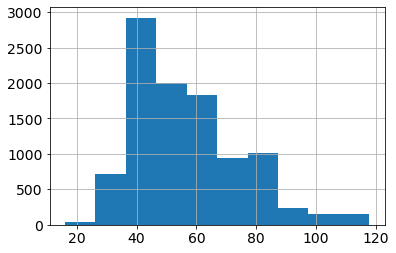

In [45]:
train_df['Square'].hist()

### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [46]:
missing_values_table(train_df)

Your selected dataframe has 24 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Healthcare_1,4798,48.0


In [47]:
# Поскольку пропущено почти половина значений попробуем заменить медианой
train_df['Healthcare_1'].fillna(train_df['Healthcare_1'].median(), inplace=True)

In [48]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,HouseYear_outlier
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887600,56.793141,34.222355,6.238200,7.400900,12.95910,1984.872600,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.001200,0.018900,0.182500,0.000200
std,0.811438,18.045763,12.482189,2.794717,5.033817,6.44346,18.416734,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.034622,0.136179,0.386275,0.014141
min,1.000000,16.000000,10.000000,3.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000
25%,1.000000,42.430539,25.527399,3.000000,3.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000,0.000000
50%,2.000000,53.352354,32.781260,6.000000,6.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000,0.000000
75%,2.000000,66.917891,39.966602,8.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000,0.000000
max,5.000000,117.856115,80.664209,13.000000,42.000000,117.00000,2021.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000


In [49]:
class DataPipeline:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.lifesquare_quantile = None
        self.square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.lifesquare_quantile = X['LifeSquare'].quantile(.975)
        self.square_quantile = X['Square'].quantile(.99)
           
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition_kitchen = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X['KitchenSquare_outlier'] = 0
        X.loc[condition_kitchen, 'KitchenSquare_outlier'] = 1
        
        X.loc[condition_kitchen, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # LifeSquare

        condition_life_square = (X['LifeSquare'].isna()) \
             | (X['LifeSquare'] > self.lifesquare_quantile)
        
        X.loc[condition_life_square, 'LifeSquare'] = self.medians['LifeSquare']
        X.loc[X['LifeSquare'] < 10, 'LifeSquare'] = 10
        
        # Square

        condition_max_square = X['Square'] > self.square_quantile
        condition_min_square = X['Square'] < X['LifeSquare'] + X['KitchenSquare'] + 3 

        X.loc[condition_max_square, 'Square'] = X['Square'].quantile(.99)
        X.loc[condition_min_square, 'Square'] = X.loc[condition_min_square,'LifeSquare'] \
                                                + X.loc[condition_min_square,'KitchenSquare'] + 3
        
        # Если встретятся пропуски - заполняем медианами
        X.fillna(self.medians, inplace=True)
        
        return X

### 4. Построение новых признаков  <a class='anchor' id='feature'>

**Dummies**

In [50]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

In [51]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [52]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,HouseYear_outlier,DistrictSize
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,900.0,0,0,1,305018.871089,0,0,0,0,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,1,177734.553407,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,1,282078.720850,0,0,0,0,652
3,2352,1,1.0,40.409907,32.781260,3.0,10,22.0,1977,0.007122,...,900.0,0,1,1,168106.007630,0,0,0,0,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,900.0,0,6,1,343995.102962,0,0,0,0,89


In [53]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [54]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByFloorYear**

In [55]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [56]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [57]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [58]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,HouseYear_outlier,DistrictSize,IsDistrictLarge,year_cat,floor_cat
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,1,305018.871089,0,0,0,0,851,1,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,177734.553407,0,0,0,0,78,0,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,0,0,0,0,652,1,4,1
3,2352,1,1.0,40.409907,32.781260,3.0,10,22.0,1977,0.007122,...,1,168106.007630,0,0,0,0,652,1,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,343995.102962,0,0,0,0,89,0,3,5


In [59]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,377548.385806
1,1,2,322905.044793
2,1,3,429458.388683
3,1,4,274992.472366
4,2,1,467230.539057


In [60]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,HouseYear_outlier,DistrictSize,IsDistrictLarge,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,0,0,851,1,6,2,162124.189453
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,0,78,0,3,3,192538.872015
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,0,652,1,4,1,206782.391302
3,2352,1,1.0,40.409907,32.781260,3.0,10,22.0,1977,0.007122,...,168106.007630,0,0,0,0,652,1,3,4,183505.979560
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,0,89,0,3,5,171739.199220


In [61]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
                 
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            # X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

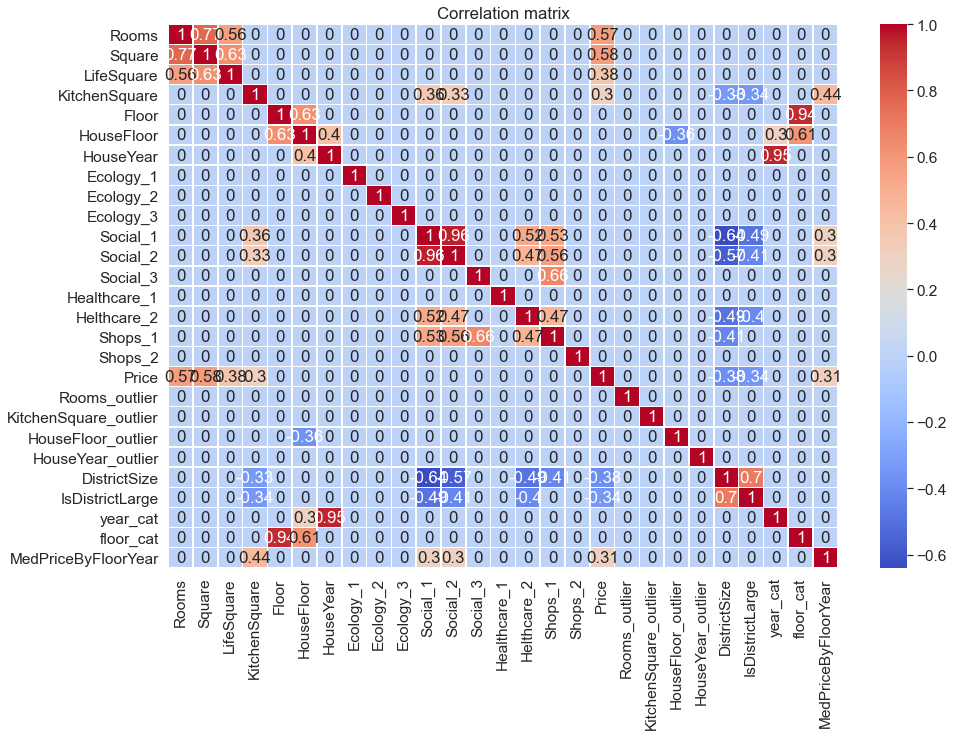

In [62]:
# МАТРИЦА КОРРЕЛЯЦИИ

plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Floor HouseYear сильно коррелируют с year_cat и floor_cat но по ним мы ничего не делаем

Social_1 и Social_2 сильно коррелируют между собой, оставим только первый

In [63]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'HouseFloor', 
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'KitchenSquare_outlier', 'HouseYear_outlier', 'DistrictSize',
                     'IsDistrictLarge', 'MedPriceByFloorYear', 'floor_cat', 'year_cat']
target_name = 'Price'

# 'new_district'  'Floor' 'HouseYear'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [64]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [65]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [66]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6700, 19), (3300, 19), (6700,), (3300,))

In [67]:
pipe = DataPipeline()
pipe.fit(X_train)

X_train = pipe.transform(X_train)
X_valid = pipe.transform(X_valid)
test_df = pipe.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

In [68]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [69]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [70]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели  <a class='anchor' id='modeling'>

**Обучение модели**

In [71]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()


rf_1 = RandomForestRegressor(criterion='mse',
                             max_depth=50, # глубина дерева  
                             random_state=42,
                             max_features=7,
                             n_estimators=1200,  # кол-во деревьев
                             n_jobs = -1
                            )
rf_2 = RandomForestRegressor(criterion='mse',
                             max_depth=15, # глубина дерева  
                             random_state=42,
                             max_features=7,
                             n_estimators=200,  # кол-во деревьев
                             n_jobs = -1
                            )

gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=500,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=100
                                     )

rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=50, # глубина дерева  
                                 min_samples_leaf=10, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=20,  # кол-во деревьев
                                 n_jobs = -1
                                 )


stack = StackingRegressor([('lr', lr), ('rf_1', rf_1), ('rf_2', rf_2), ('gb', gb_model)], final_estimator=rf_model)
# stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
stack.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf_1',
                               RandomForestRegressor(max_depth=50,
                                                     max_features=7,
                                                     n_estimators=1200,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('rf_2',
                               RandomForestRegressor(max_depth=15,
                                                     max_features=7,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(criterion='mse',
                                                         max_depth

Train R2:	0.938
Test R2:	0.724


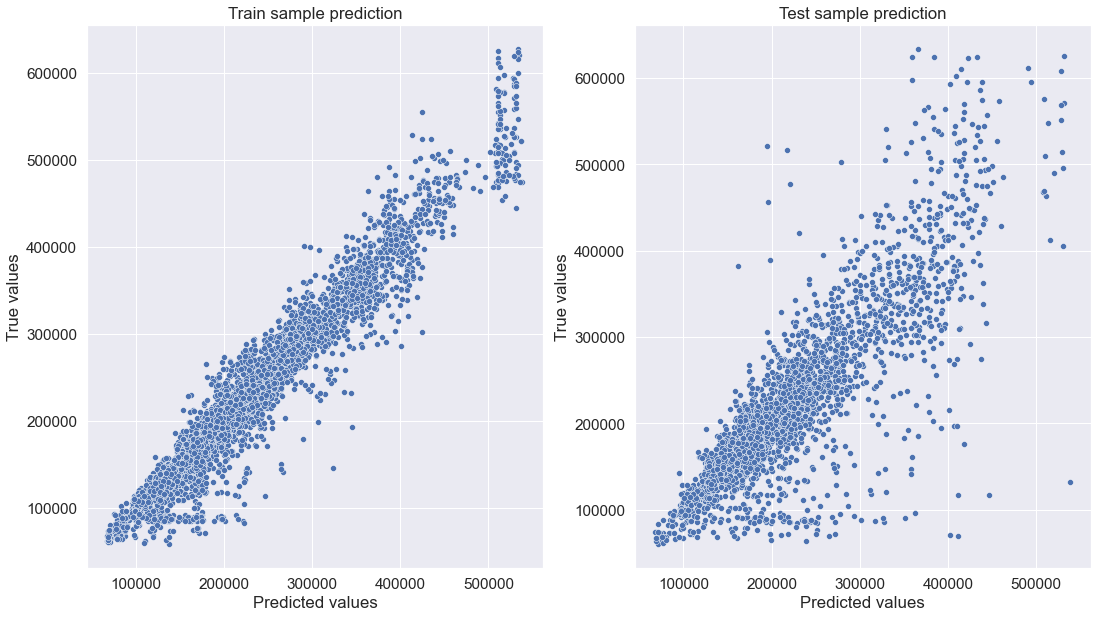

In [72]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

In [73]:
test_df.shape

(5000, 22)

In [74]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [75]:
predictions_stack = stack.predict(test_df)
predictions_stack

array([158280.14386251, 116238.58283558, 143642.0601364 , ...,
       142106.07859329, 190399.19321479, 250239.36306959])

In [76]:
submit['Price'] = predictions_stack
submit.head()

,Id,Price
0,4567,158280.143863
1,5925,116238.582836
2,960,143642.060136
3,3848,135930.320151
4,746,186935.099858


In [77]:
submit.to_csv('stack_submit.csv', index=False)